In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import mstats
import os
import importlib

In [13]:
# --- Step 1: Load Data ---
file_path = os.getcwd() + '/data/Factor_data.xlsx'
df = pd.read_excel(file_path, sheet_name='dc_fund', index_col=0)
df = df.tail(24).copy()

"""
# Winsorize and standardize factors
for col in ['Quality', 'Momentum', 'Value', 'Low_vol', 'Market']:
    df[col] = mstats.winsorize(df[col], limits=[0.05, 0.05])
    df[col] = (df[col] - df[col].mean()) / df[col].std()
"""

"\n# Winsorize and standardize factors\nfor col in ['Quality', 'Momentum', 'Value', 'Low_vol', 'Market']:\n    df[col] = mstats.winsorize(df[col], limits=[0.05, 0.05])\n    df[col] = (df[col] - df[col].mean()) / df[col].std()\n"

In [14]:
market_neutral_factors = {}

for factor in ['Quality', 'Momentum', 'Value', 'Low_vol']:
    # Prepare regression variables
    x_market = sm.add_constant(df['Market'])
    y_factor = df[factor]

    
    # Run regression
    model = sm.OLS(y_factor, x_market).fit()
    
    # Get residuals (market-neutral factor returns)
    market_neutral_factors[factor] = model.resid

# Add market-neutral factors to DataFrame
for factor in market_neutral_factors:
    df[f'{factor}_mn'] = market_neutral_factors[factor]

# Now use ['Quality_mn', 'Momentum_mn', 'Value_mn', 'Low_vol_mn'] as your factors in further analysis

print(df.columns)

Index(['Net Return', 'Benchmark Return', 'Quality', 'Momentum', 'Value',
       'Low_vol', 'Market', 'Quality_mn', 'Momentum_mn', 'Value_mn',
       'Low_vol_mn'],
      dtype='object')


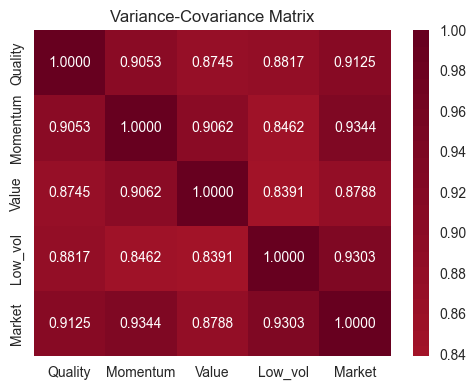

In [22]:
import libraries.help as help
importlib.reload(help)

df_corr = df[['Quality', 'Momentum', 'Value', 'Low_vol', 'Market']].corr()
help.plot_covariance_matrix(df_corr, instrument_names=['Quality', 'Momentum', 'Value', 'Low_vol', 'Market'])

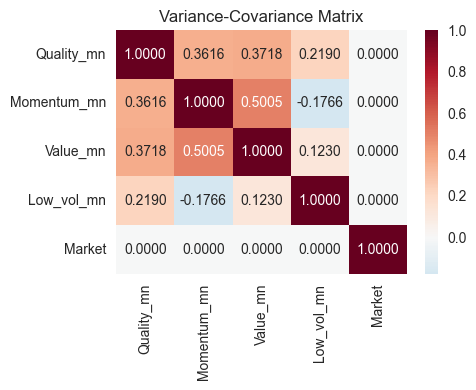

In [23]:
df_corr = df[['Quality_mn', 'Momentum_mn', 'Value_mn', 'Low_vol_mn', 'Market']].corr()

help.plot_covariance_matrix(df_corr, instrument_names=['Quality_mn', 'Momentum_mn', 'Value_mn', 'Low_vol_mn', 'Market'])

In [17]:
# --- Step 3: Prepare Regression Variables ---
X = df[['Quality_mn', 'Momentum_mn', 'Value_mn', 'Low_vol_mn', 'Market']]
# X = df[['Quality', 'Momentum', 'Value', 'Low_vol']] 
y = df['Net Return']  # or df['Benchmark Return']

# Add constant for intercept
X = sm.add_constant(X)

# --- Step 4: Run Regression ---
model = sm.OLS(y, X).fit()
print(model.summary())

# --- Step 5: Get Betas (Factor Sensitivities) ---
betas = model.params.drop('const')
print(betas)

                            OLS Regression Results                            
Dep. Variable:             Net Return   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     2.188
Date:                Tue, 16 Sep 2025   Prob (F-statistic):              0.101
Time:                        11:01:03   Log-Likelihood:                 91.717
No. Observations:                  24   AIC:                            -171.4
Df Residuals:                      18   BIC:                            -164.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0092      0.001      7.090      

In [18]:
# --- Step 6: Calculate Factor Variances and Covariances ---
factor_returns = df[['Quality_mn', 'Momentum_mn', 'Value_mn', 'Low_vol_mn', 'Market']]
#factor_returns = df[['Quality', 'Momentum', 'Value', 'Low_vol']] 
factor_cov = factor_returns.cov()
factor_var = factor_returns.var()

factor_cov

,Quality_mn,Momentum_mn,Value_mn,Low_vol_mn,Market
Quality_mn,4.725405e-04,1.767373e-04,2.314677e-04,6.721852e-05,3.865416e-19
Momentum_mn,1.767373e-04,5.056763e-04,3.222719e-04,-5.608919e-05,4.572505e-19
Value_mn,2.314677e-04,3.222719e-04,8.200273e-04,4.973567e-05,6.693770e-19
Low_vol_mn,6.721852e-05,-5.608919e-05,4.973567e-05,1.994157e-04,5.468150e-19
Market,3.865416e-19,4.572505e-19,6.693770e-19,5.468150e-19,1.703626e-03


In [ ]:
# --- Step 7: Calculate Risk Attribution ---
# Portfolio variance explained by factors
risk_contributions = {}
for i, factor in enumerate(factor_returns.columns):
    # Variance term
    var_term = betas[factor]**2 * factor_var[factor]
    # Covariance terms
    cov_term = 0
    for j, other_factor in enumerate(factor_returns.columns):
        if i != j:
            cov_term += betas[factor] * betas[other_factor] * factor_cov.loc[factor, other_factor]
    # Total contribution
    risk_contributions[factor] = var_term + cov_term

# Residual (unexplained) risk
residual_var = model.resid.var()

# --- Step 8: Summarize Results ---
total_risk = sum(risk_contributions.values()) + residual_var

print("\nRisk Attribution (Absolute):")
for factor, contribution in risk_contributions.items():
    print(f"{factor}: {contribution:.6f} ({contribution/total_risk:.2%} of total risk)")
print(f"Residual: {residual_var:.6f} ({residual_var/total_risk:.2%} of total risk)")
print(f"Total Portfolio Variance: {total_risk:.6f}")

Portfolio Risk Attribution Analysis
Total Portfolio Variance: 0.000047

Risk Attribution Table:
     Factor  Absolute_Risk  Risk_Percentage
 Quality_mn  -3.173791e-07        -0.674128
Momentum_mn   5.766643e-07         1.224861
   Value_mn   5.253460e-06        11.158585
 Low_vol_mn   4.859345e-06        10.321467
     Market   7.422932e-06        15.766641
   Residual   2.928496e-05        62.202573


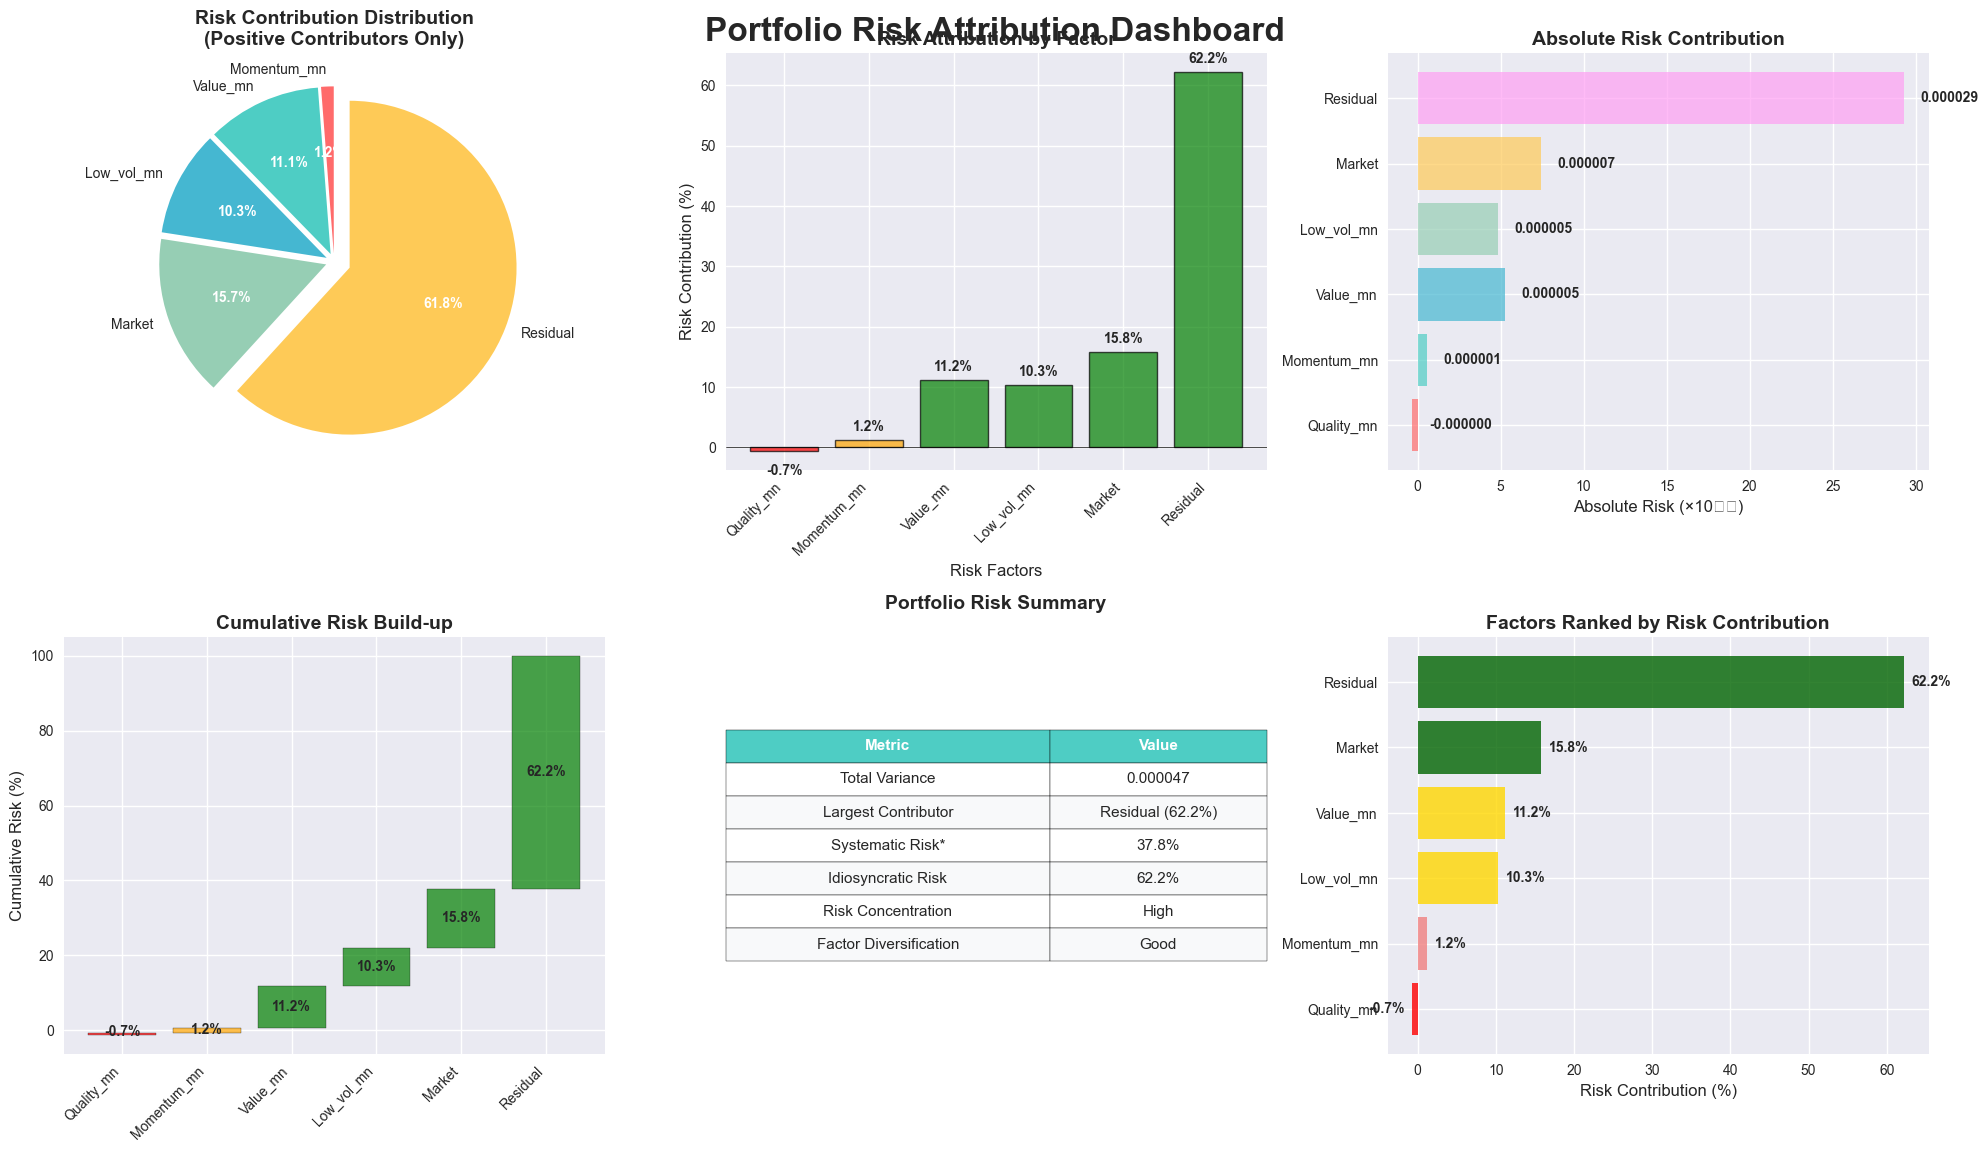


RISK ANALYSIS INSIGHTS

🔍 KEY FINDINGS:
• Residual risk dominates the portfolio (62.2%)
• Systematic risk factors contribute 37.8% of total risk
• Residual is the largest systematic contributor (62.2%)
• Portfolio shows MODERATE concentration risk

📊 RISK DECOMPOSITION:
• Quality_mn  :  -0.67% 🟢 LOW
• Momentum_mn :   1.22% 🟢 LOW
• Value_mn    :  11.16% 🟡 MEDIUM
• Low_vol_mn  :  10.32% 🟡 MEDIUM
• Market      :  15.77% 🟡 MEDIUM
• Residual    :  62.20% 🔴 HIGH

💡 RECOMMENDATIONS:
• Consider increasing factor exposure to reduce idiosyncratic risk

Note: *Systematic Risk = Sum of all factor risks excluding residual


In [ ]:
import libraries.help as help
importlib.reload(help)

# Build dataframe
df = pd.DataFrame([
    {"Factor": factor,
     "Absolute_Risk": contrib,
     "Risk_Percentage": (contrib / total_risk) * 100}
    for factor, contrib in risk_contributions.items()
] + [{
    "Factor": "Residual",
    "Absolute_Risk": residual_var,
    "Risk_Percentage": (residual_var / total_risk) * 100
}])

help.plot_risk_attribution(df, total_risk, title="Portfolio Risk Attribution Dashboard")

In [25]:
# --- Step 9: Attribution Calculation ---
betas = model.params.drop('const')
alpha = model.params['const']
avg_factors = X.drop('const', axis=1).mean()

# Factor contributions
factor_contributions = betas * avg_factors

# Alpha contribution
alpha_contribution = alpha

# Residual (unexplained) contribution
residuals = model.resid
residual_contribution = residuals.mean()

# Total (should match average net return)
total_contribution = factor_contributions.sum() + alpha_contribution + residual_contribution

# --- Step 6: Display Results ---
print("Return Attribution (last 36 rows):")
print(f"Alpha: {alpha_contribution:.6%}")
for factor in betas.index:
    print(f"{factor}: {factor_contributions[factor]:.6%}")
print(f"Residual: {residual_contribution:.6%}")
print(f"Total: {total_contribution:.6%} (should match average Net Return: {y.mean():.6%})")

Return Attribution (last 36 rows):
Alpha: 0.928872%
Quality_mn: 0.000000%
Momentum_mn: 0.000000%
Value_mn: -0.000000%
Low_vol_mn: -0.000000%
Market: 0.086211%
Residual: 0.000000%
Total: 1.015083% (should match average Net Return: 1.015083%)


,Quality,Momentum,Value,Low_vol
Quality,1.000000,0.896456,0.835524,0.865622
Momentum,0.896456,1.000000,0.868006,0.838115
Value,0.835524,0.868006,1.000000,0.840170
Low_vol,0.865622,0.838115,0.840170,1.000000


,Quality_mn,Momentum_mn,Value_mn,Low_vol_mn,Market
Quality_mn,1.000000e+00,3.586336e-01,2.358629e-01,1.362120e-01,4.796953e-16
Momentum_mn,3.586336e-01,1.000000e+00,3.572802e-01,-1.483210e-01,5.140398e-16
Value_mn,2.358629e-01,3.572802e-01,1.000000e+00,1.917020e-01,4.649157e-16
Low_vol_mn,1.362120e-01,-1.483210e-01,1.917020e-01,1.000000e+00,2.627379e-16
Market,4.796953e-16,5.140398e-16,4.649157e-16,2.627379e-16,1.000000e+00
